<!-- The loan dataset is a collection of information about people who applied for loans in the past,
along with whether their loan was approved or rejected. It contains details about each applicant,
such as their gender, marital status, number of dependents, education level, income,
the loan amount they requested, and how long they want to repay it. It also includes their credit 
history, which shows if they have previously paid loans on time. The final column,
 called Loan_Status, tells whether the bank approved the loan or not. By studying these patterns,
 a machine learning model can learn how banks make decisions and can predict whether a new applicant’s
 loan should be approved.  -->

In [69]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin

In [5]:
class OutlierToMedianTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
        self.bounds_ = {}

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X, columns=self.feature_names)
        for col in self.feature_names:
            Q1 = X_df[col].quantile(0.25)
            Q3 = X_df[col].quantile(0.75)
            IQR = Q3 - Q1
            self.bounds_[col] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X, columns=self.feature_names)
        for col, (lower, upper) in self.bounds_.items():
            X_df[col] = np.where((X_df[col] < lower) | (X_df[col] > upper), np.nan, X_df[col])
        return X_df.values

def clean_col_name(col):
    col = col.strip().lower()
    col = re.sub(r'[^\w]+', '_', col)
    col = col.strip('_')
    return col

In [6]:
df = pd.read_csv(r"C:\Users\Noman Traders\Downloads\Housing.csv")
df.columns = [clean_col_name(col) for col in df.columns]

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price_target      545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [8]:
target_col = 'price'
df.rename(columns={target_col:'price_target'}, inplace=True)
target_col = 'price_target'

In [ ]:
## remove duplicate if exist
df.drop_duplicates(inplace=True)
df = df.dropna(subset=[target_col])

In [10]:
df.columns

Index(['price_target', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [11]:
X = df.drop(df[["price_target"]], axis=1)
Y = df[target_col]

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [13]:
X_train.head(3)

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
46,6000,3,2,4,yes,no,no,no,yes,1,no,furnished
93,7200,3,2,1,yes,no,yes,no,yes,3,no,semi-furnished
335,3816,2,1,1,yes,no,yes,no,yes,2,no,furnished


In [31]:
Y_train.head(3)

46     7525000
93     6300000
335    3920000
Name: price_target, dtype: int64

In [15]:
numericals_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

In [16]:
skewness = X_train[numericals_cols].apply(lambda x: x.skew()).abs()
skew_threshold = 0.5

In [17]:
skewed_cols = skewness[skewness >= skew_threshold].index.tolist()
normal_cols = skewness[skewness < skew_threshold].index.tolist()

In [45]:
skewed_pipe = Pipeline(steps=[
    ('outliers', OutlierToMedianTransformer(feature_names=skewed_cols)),
    ('imputer', SimpleImputer(strategy='median')),
    ('power', PowerTransformer(method='yeo-johnson')),
    ('scale', StandardScaler())
])

C:\Users\Noman Traders\AppData\Local\Temp\ipykernel_4892\2348864498.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["area"])


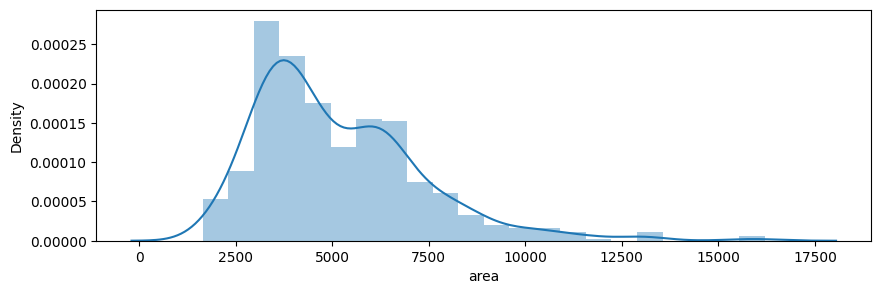

In [128]:
plt.figure(figsize=(10, 3))
sns.distplot(df["area"])
plt.show()

In [46]:
if not normal_cols:
    normal_pipe = 'drop' 
else:
    normal_pipe = Pipeline(steps=[
        ('outlier', OutlierToMedianTransformer(feature_names=normal_cols)),
        ('imputer', SimpleImputer(strategy='mean')),
        ('scale', StandardScaler())
    ])

In [47]:
cat_pipe = Pipeline(steps=[
    ('imputeer', SimpleImputer(strategy="most_frequent")),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

In [48]:
preprocessor = ColumnTransformer(
    transformers=[
        ('skewed_proc', skewed_pipe, skewed_cols),
        ('normal_proc', normal_pipe, normal_cols),
        ('cat_proc', cat_pipe, categorical_cols)
    ],
    remainder='drop'
)

In [121]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    # ('model', LinearRegression()),
    # ('model', Ridge(alpha=0.0001)),
    ('model', Lasso(alpha=0.0001))
])

In [122]:
model_pipeline.fit(X_train, Y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('skewed_proc', ...), ('normal_proc', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [123]:
y_pred = model_pipeline.predict(X_test)

In [124]:
mse = mean_squared_error(Y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, y_pred)

In [125]:
print("Mean Square Error: ",mse)
print("Root Mean Square Error: ", rmse)
print(f"R2: {r2*100.:2f}")

Mean Square Error:  1918457775797.7913
Root Mean Square Error:  1385084.0320348046
R2: 62.045086


In [102]:
first_skewed_col = skewed_cols[0]
first_skewed_index = preprocessor.transformers_[0][2].index(first_skewed_col)
X_train_transformed = model_pipeline['preprocessor'].transform(X_train)

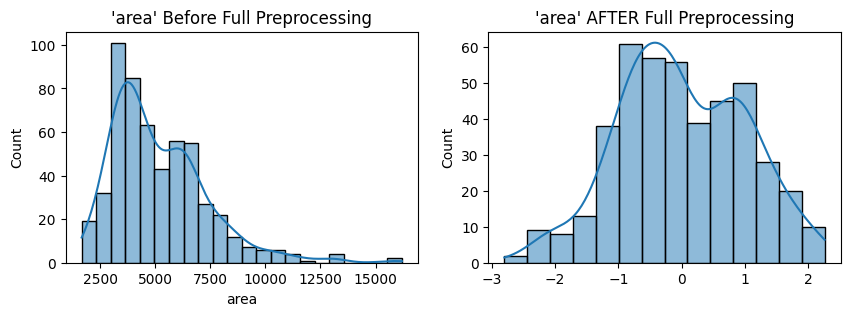

In [136]:
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
sns.histplot(df["area"], kde=True)
plt.title(f"'{first_skewed_col}' Before Full Preprocessing")

plt.subplot(1, 2, 2)
sns.histplot(X_train_transformed[:, first_skewed_index], kde=True)
plt.title(f"'{first_skewed_col}' AFTER Full Preprocessing")
plt.show()

In [133]:
from sklearn import set_config
set_config(display='diagram')
model_pipeline

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('skewed_proc', ...), ('normal_proc', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [134]:
import cloudpickle

with open("model.pkl", "wb") as f:
    cloudpickle.dump(model_pipeline, f)
